# import 工具，导入源数据

In [1]:
import os
os.getcwd()

'C:\\Users\\Michael\\0.UniversityOfWaterloo_Homepage\\MSCI609\\0.FinalProject'

In [2]:
import lightgbm as lgb

import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier # GBDT-Gradient Bosting decision tree
from sklearn.preprocessing import LabelEncoder # For transition
from sklearn.metrics import roc_curve,auc
from scipy import interp
import matplotlib.pyplot as plt
import seaborn as sns

filePath_01="indl.xlsx" #修改
# filePath_02="indl_fs.xlsx" #修改
df1 = pd.read_excel(filePath_01)
# df2 = pd.read_excel(filePath_02)

In [163]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8286 entries, 0 to 8285
Data columns (total 58 columns):
 #   Column                                                                        Non-Null Count  Dtype         
---  ------                                                                        --------------  -----         
 0   Global Company Key                                                            8286 non-null   int64         
 1   Industry Format                                                               8286 non-null   object        
 2   Data Format                                                                   8286 non-null   object        
 3   Level of Consolidation                                                        8286 non-null   object        
 4   Population Source                                                             8286 non-null   object        
 5   Pension - Accumulated Benefit Obligation                                      4705 non-nul

In [164]:
def missing_values_table(df):
    mis_val = df.isnull().sum() # 总缺失值
    mis_val_percent = 100 * df.isnull().sum() / len(df) # 缺失值比例
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1) # 缺失值制成表格
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0:'Missing Values',
                                                               1:'% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values',ascending=False).round(1)
    # 缺失值比例列由大到小排序
    
    print('Your selected dataframe has {} columns.\nThere are {} columns that have missing values.'.format(df.shape[1], mis_val_table_ren_columns.shape[0]))
    # 打印缺失值信息
    
    return mis_val_table_ren_columns

In [165]:
missing_values_table(df1)

Your selected dataframe has 58 columns.
There are 52 columns that have missing values.


,Missing Values,% of Total Values
Postretirement Unrecognized Transition Obligations,8286,100.0
Pension - Accumulated Benefit Obligation (Underfunded),8286,100.0
Pension Plan Assets (Underfunded),8286,100.0
Pension Benefits - Net Assets,8286,100.0
Pension Benefits - Present Value of Vested,8286,100.0
Pension - Prepaid Benefit Cost - Asset Data Code,8286,100.0
Pension Plans - Other Periodic Cost Components (Net) Data Code,8265,99.7
Postretirement Beginning Plan Assets Data Code,8252,99.6
Postretirement Benefit Asset Data Code,8249,99.6
Pension Benefits Paid Data Code,8223,99.2


In [169]:
df1[["Postretirement Unrecognized Transition Obligations",
     "Pension - Accumulated Benefit Obligation (Underfunded)",
     "Postretirement - Amortization of Unrecognized Transition Obligation",
    "Postretirement Benefit Obligation",
     "Pension - Projected Benefit Obligation"]]

KeyError: "['Postretirement Unrecognized Transition Obligations', 'Pension - Accumulated Benefit Obligation (Underfunded)'] not in index"

# 挑选出缺失值不大于60% 的Variable作为解释变量

In [166]:
filer_list = missing_values_table(df1)
delete_selected_feature = filer_list[filer_list["% of Total Values"]>= 60].index
print(len(delete_selected_feature))

Your selected dataframe has 58 columns.
There are 52 columns that have missing values.
17


In [168]:
df1 = df1.drop(delete_selected_feature,axis=1)

# 选取Y variable

Projected Benefit Obligation

累积给付义务（accumulated benefit obligation简称ABO）与预计给付义务（projected benefit obligation简称PBO）。ABO与PBO均指预期未来要支付的养老金的精算现值。两者的区别在于：ABO是以现有的工资水平为基础计算的，PBO是以未来的工资水平为基础计算的。大多数人认为，ABO更符合负债定义，因为负债的存在只能基于过去已发生的事项而不是未来事项，ABO以现有的工资水平为基础，所提供的会计信息更具有可靠性；但也有人认为，ABO以现有的工资水平计算虽然减少了不确定性，但无法真实地反映出企业未来的养老金给付义务，缺乏相关性。在持续经营的会计假设下，建立在未来工资水平的基础之上的PBO是企业未来最可能履行的义务，它直接影响着企业未来的现金流量，同时也更具有不确定性。在约定给付养老金计划下，主要运用PBO计算养老金成本与负债，ABO只是在计算最小负债（the minimum liability）时用到。因此，在探讨不确定性对养老金会计的影响时，主要考虑不确定性对PBO的影响。

In [170]:
# 查询重复的内容
df1[df1.duplicated()]# 无重复行

,Global Company Key,Industry Format,Data Format,Level of Consolidation,Population Source,Pension - Accumulated Benefit Obligation,Pension - Long-Term Asset,Pension Actual Return on Plan Assets,Pension Beginning Plan Assets,Pension Employer Contribution,...,Postretirement Other Adjustments (Plan Assets),Postretirement Other Adjustments (Net Benefit Asset/Liability),Postretirement Net Total Other Costs,Postretirement Benefits Paid,Postretirement Participant Contributions,Postretirement Prior Service,Postretirement Service Cost,Data Date,Pension Benefit - Information Date,Ticker Symbol


# 数据筛选逻辑： Y variable 没有缺失 -> 把原始数据的非相关变量删除（“与研究课题无关的变量”删除）


In [172]:
len(df1["Global Company Key"].unique())#1217 #6-> 

2341

In [173]:
print(len(df1["Ticker Symbol"].value_counts().values))
df1["Ticker Symbol"].value_counts()
print(df1["Ticker Symbol"].value_counts().index.unique())

2340
Index(['AIR', 'CLVT', 'SPHR', 'NLSP', 'VNT', 'CARR', 'OTIS', 'ARNC', 'KLR',
       'REYN',
       ...
       'NOTV', 'CUB', 'MCB', 'VRTU', 'GVMUF', 'WBC', 'CZZ', 'LBC', 'PUSH',
       'ACLLY'],
      dtype='object', name='Ticker Symbol', length=2340)


## 有 2341家上市公司

In [174]:
df1.head()
df1["Pension Benefit - Information Date"]
# df1["Data Date"]

0      2020-05-31
1      2021-05-31
2      2022-05-31
3      2023-05-31
4      2019-12-31
          ...    
8281   2021-12-31
8282   2022-12-31
8283   2021-12-31
8284   2022-12-31
8285   2022-12-31
Name: Pension Benefit - Information Date, Length: 8286, dtype: datetime64[ns]

# Data Preprocessing
1)修改列名，变得更加合理；同时，每个变量的含义需要理解！

2)缺失值如何根据1)的理解，对其进行处理? 0 算是缺失值吗？

3)处理duplicate的值

In [175]:
df1["Global Company Key"] = df1["Global Company Key"].astype("object") #转化为object，为缺失值处理做铺垫
#删除无关的变量,并筛选出 Y variable 非空的数据行
df1 = df1[df1["Pension - Projected Benefit Obligation"].notnull().values==True].drop(["Industry Format","Data Format",
                                                                                 "Level of Consolidation","Population Source",
                                                                                 "Ticker Symbol","Data Date"],axis=1)
#如何批量修改列名，变得更加合理； 同时，每个变量的含义需要理解！
df1 = df1.rename(columns={'Pension Benefit - Information Date':'Record_Date'})  #把 左，改成 右

In [177]:
df1 = df1.drop(["Postretirement - Amortization of Unrecognized Transition Obligation"],axis=1)

## Y variable 非空:7175 rows

# 缺失数据

没有高质量的数据，就没有高质量的数据挖掘结果，数据值缺失是数据分析中经常遇到的问题之一。当缺失比例很小时，可直接对缺失记录进行舍弃或进行手工处理。但在实际数据中，往往缺失数据占有相当的比重。这时如果手工处理非常低效，如果舍弃缺失记录，则会丢失大量信息，使不完全观测数据与完全观测数据间产生系统差异，对这样的数据进行分析，你很可能会得出错误的结论。
造成数据缺失的原因
现实世界中的数据异常杂乱，属性值缺失的情况经常发全甚至是不可避免的。造成数据缺失的原因是多方面的：
信息暂时无法获取。例如在医疗数据库中，并非所有病人的所有临床检验结果都能在给定的时间内得到，就致使一部分属性值空缺出来。
信息被遗漏。可能是因为输入时认为不重要、忘记填写了或对数据理解错误而遗漏，也可能是由于数据采集设备的故障、存储介质的故障、传输媒体的故障、一些人为因素等原因而丢失。
有些对象的某个或某些属性是不可用的。如一个未婚者的配偶姓名、一个儿童的固定收入状况等。
有些信息（被认为）是不重要的。如一个属性的取值与给定语境是无关。
获取这些信息的代价太大。
系统实时性能要求较高。即要求得到这些信息前迅速做出判断或决策。
对缺失值的处理要具体问题具体分析，为什么要具体问题具体分析呢？因为属性缺失有时并不意味着数据缺失，缺失本身是包含信息的，所以需要根据不同应用场景下缺失值可能包含的信息进行合理填充。

In [176]:
print(df1["Record_Date"].min())
print(df1["Record_Date"].max())

2019-10-31 00:00:00
2023-09-30 00:00:00


In [113]:
# df1.drop(df1[df1["Record_Date"].isnull() == True].index, inplace=True)
# df1.drop(df1[df1["Global Company Key"].isnull() == True].index, inplace=True)

In [179]:
missing_values_table(df1)

Your selected dataframe has 34 columns.
There are 32 columns that have missing values.


,Missing Values,% of Total Values
Postretirement Other Adjustments (Net Benefit Asset/Liability),4277,59.6
Postretirement Prior Service,4258,59.3
Postretirement - Current Liability,3973,55.4
Postretirement Interest Cost,3609,50.3
Postretirement Service Cost,3600,50.2
Postretirement Net Total Other Costs,3598,50.1
Postretirement Participant Contributions,3589,50.0
Postretirement Employer Contributions,3564,49.7
Postretirement Benefits Paid,3546,49.4
Postretirement Other Adjustments (Plan Assets),3537,49.3


In [180]:
df1[df1["Record_Date"].isnull() == True]
# df1[df1["Global Company Key"].isnull() == True]

,Global Company Key,Pension - Accumulated Benefit Obligation,Pension - Long-Term Asset,Pension Actual Return on Plan Assets,Pension Beginning Plan Assets,Pension Employer Contribution,Employer Contributions - Expected Next Year,Pension - Current Liability,Pension Benefits Paid,Pension - Projected Benefit Obligation,...,Postretirement - Current Liability,Postretirement - Long-Term Liability,Postretirement Other Adjustments (Plan Assets),Postretirement Other Adjustments (Net Benefit Asset/Liability),Postretirement Net Total Other Costs,Postretirement Benefits Paid,Postretirement Participant Contributions,Postretirement Prior Service,Postretirement Service Cost,Record_Date
65,1274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
66,1274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
67,1274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
99,1487,6131.0,65.000,808.000,4701.000,241.000,65.0,NaN,338.000,6146.000,...,NaN,242.0,0.0,-4.0,-3.0,14.0,0.0,-1.0,2.0,NaT
100,1487,6623.0,73.000,797.000,5364.000,66.000,68.0,NaN,341.000,6641.000,...,NaN,262.0,0.0,21.0,-1.0,14.0,0.0,0.0,2.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8207,313966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
8208,313966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
8209,313966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
8243,323476,NaN,NaN,0.000,0.000,0.000,NaN,NaN,0.000,1.669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [181]:
nul_columns = df1.select_dtypes(include=['float64','int64']).columns
column_name = []
unique_value = []
for col_temp in nul_columns:
    #print(col, data[col].nunique())
    column_name.append(col_temp)
    # unique_value.append(data[col_temp].nunique())
print(column_name)
print(len(column_name))


final_cat_list = []
for col in df1.columns:
    # print(col, data[col].nunique())
    if (col in column_name): #) & (df1[col].nunique() >= 5
        final_cat_list.append(col)
print("==============")
print(final_cat_list)
print("符合特定筛选条件的变量有：",len(final_cat_list))

['Pension - Accumulated Benefit Obligation', 'Pension - Long-Term Asset', 'Pension Actual Return on Plan Assets', 'Pension Beginning Plan Assets', 'Pension Employer Contribution', 'Employer Contributions - Expected Next Year', 'Pension - Current Liability', 'Pension Benefits Paid', 'Pension - Projected Benefit Obligation', 'Pension Plans - Interest Cost', 'Pension Plan Assets', 'Pension Plans - Other Periodic Cost Components (Net)', 'Periodic Postretirement Benefit Cost (Net)', 'Pension Plans - Rate of Compensation Increase', 'Pension Plans - Anticipated Long-Term Rate of Return on Plan Assets', 'Pension Plans - Return on Plan Assets (Expected)', 'Pension Plans - Service Cost', 'Postretirement - Long-Term Asset', 'Post Retirement Actual Return on Plan Assets', 'Postretirement Benefit Asset', 'Postretirement Benefit Obligation', 'Postretirement Employer Contributions', 'Postretirement Interest Cost', 'Postretirement - Current Liability', 'Postretirement - Long-Term Liability', 'Postreti

In [183]:
from sklearn.impute import SimpleImputer
df_mean_machine = SimpleImputer(missing_values=np.nan, strategy='mean',copy=False)
df1_filled_missing_new = df_mean_machine.fit_transform(df1[final_cat_list].values) #只有数值

new_df1 = pd.DataFrame(df1_filled_missing_new,columns=final_cat_list)
new_df1['Global Company Key'] = df1.loc[:,'Global Company Key'].values # array的格式
new_df1['Record_Date'] = df1.loc[:,'Record_Date'].values # array的格式

In [185]:
new_df1

,Pension - Accumulated Benefit Obligation,Pension - Long-Term Asset,Pension Actual Return on Plan Assets,Pension Beginning Plan Assets,Pension Employer Contribution,Employer Contributions - Expected Next Year,Pension - Current Liability,Pension Benefits Paid,Pension - Projected Benefit Obligation,Pension Plans - Interest Cost,...,Postretirement - Long-Term Liability,Postretirement Other Adjustments (Plan Assets),Postretirement Other Adjustments (Net Benefit Asset/Liability),Postretirement Net Total Other Costs,Postretirement Benefits Paid,Postretirement Participant Contributions,Postretirement Prior Service,Postretirement Service Cost,Global Company Key,Record_Date
0,151.900000,0.000,8.600,129.900,0.400,3.100000,0.400000,7.100,159.100,3.800,...,0.400000,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2020-05-31
1,153.000000,10.400,23.800,131.800,2.700,2.300000,0.400000,6.800,159.000,3.100,...,178.892536,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2021-05-31
2,116.500000,9.700,-16.700,158.400,0.500,0.300000,0.300000,7.600,120.200,3.100,...,178.892536,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2022-05-31
3,105.300000,8.700,-7.400,126.200,0.300,0.400000,0.200000,5.800,108.000,3.300,...,178.892536,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2023-05-31
4,2007.997043,0.000,0.643,5.819,0.300,40.814273,0.000000,0.525,8.662,0.319,...,0.072000,0.000000,0.038000,0.003000,0.017000,0.000000,0.00000,0.000000,1019,2019-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7170,2007.997043,9.099,369.631,6419.067,255.898,456.068000,0.000000,194.483,9042.877,109.183,...,706.279000,0.000000,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2021-12-31
7171,2007.997043,49.162,-1062.329,6528.946,339.860,241.536000,0.000000,203.061,6308.785,140.005,...,594.221000,0.000000,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2022-12-31
7172,2007.997043,14.895,-2.709,897.768,40.624,37.915000,7.044455,24.374,1113.070,1.354,...,135.410000,0.642125,-0.089208,0.000000,18.182696,0.000000,-18.60939,10.833000,353444,2021-12-31
7173,2007.997043,30.123,-150.612,819.332,33.737,28.918000,7.044455,49.401,778.365,1.205,...,101.212000,0.642125,-0.089208,0.000000,18.182696,0.000000,-18.60939,8.434000,353444,2022-12-31


In [192]:
missing_values_table(new_df1)

Your selected dataframe has 34 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Record_Date,787,11.0


In [195]:
new_df1 = new_df1[new_df1["Record_Date"].isnull() != True]

In [199]:
missing_values_table(new_df1)

Your selected dataframe has 34 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [196]:
new_df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6388 entries, 0 to 7174
Data columns (total 34 columns):
 #   Column                                                               Non-Null Count  Dtype         
---  ------                                                               --------------  -----         
 0   Pension - Accumulated Benefit Obligation                             6388 non-null   float64       
 1   Pension - Long-Term Asset                                            6388 non-null   float64       
 2   Pension Actual Return on Plan Assets                                 6388 non-null   float64       
 3   Pension Beginning Plan Assets                                        6388 non-null   float64       
 4   Pension Employer Contribution                                        6388 non-null   float64       
 5   Employer Contributions - Expected Next Year                          6388 non-null   float64       
 6   Pension - Current Liability                          

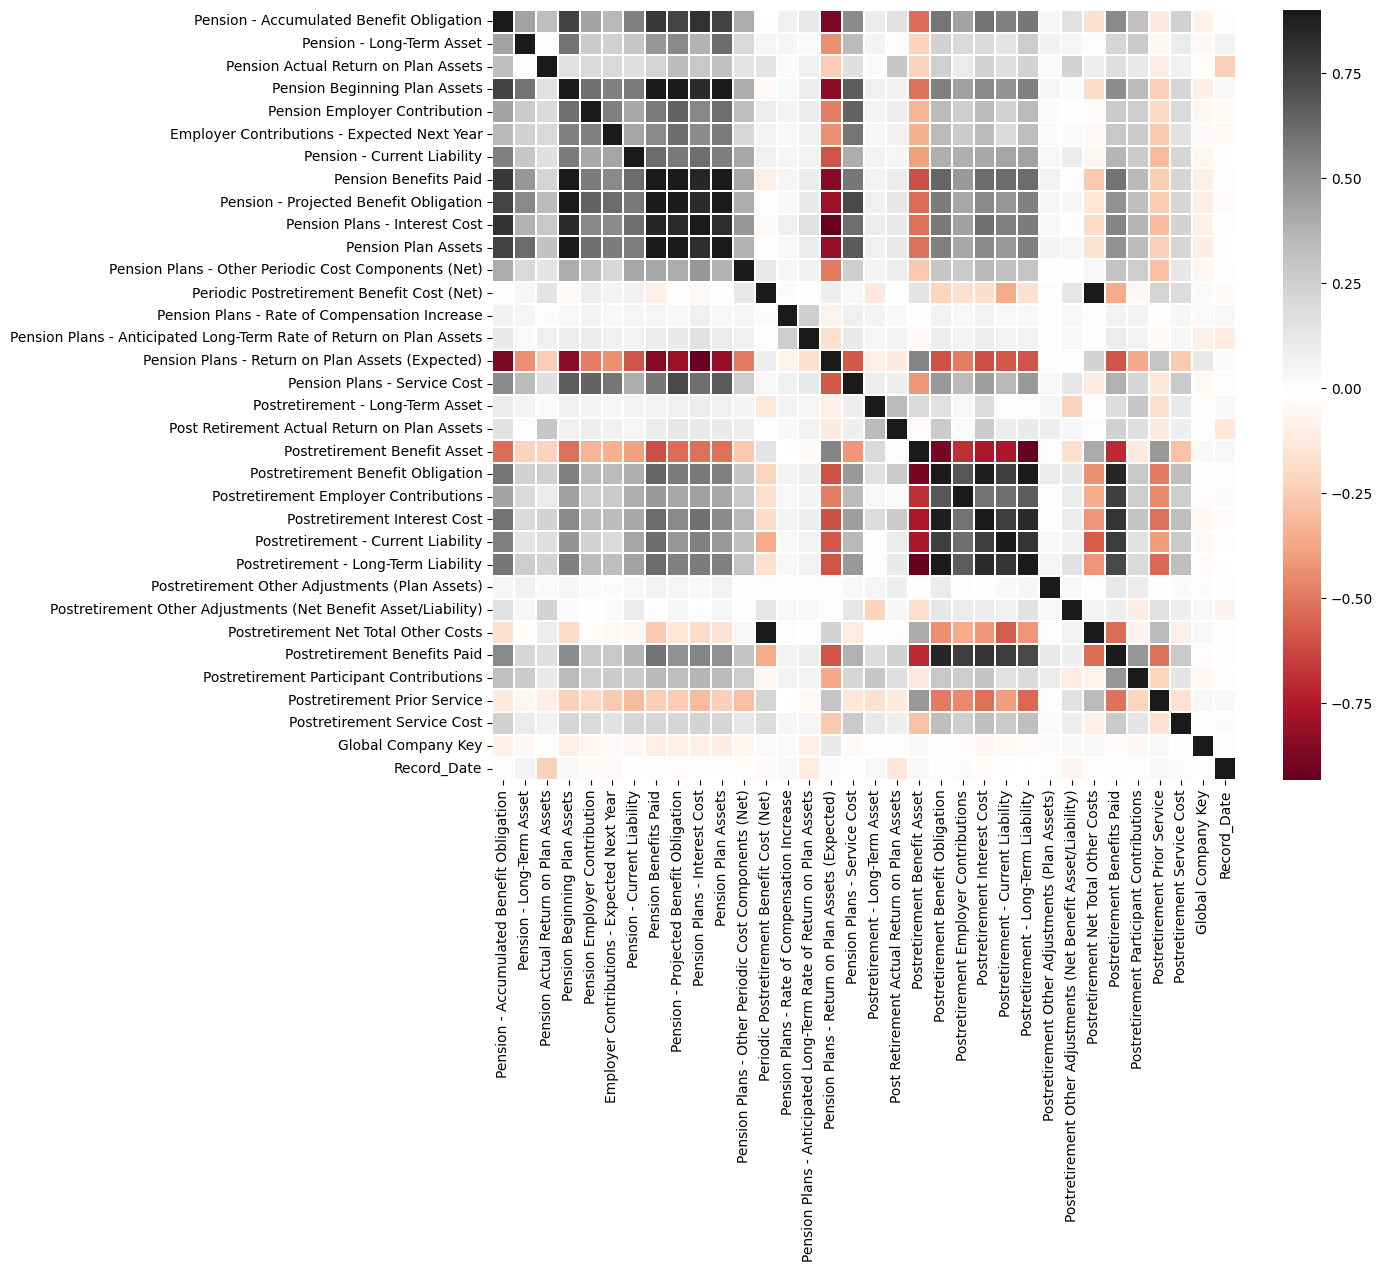

In [197]:
# 计算并绘制相关系数矩阵
correlation_matrix = new_df1.corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix,vmax=0.9,linewidths=0.05,cmap="RdGy")
plt.show()

In [198]:
new_df1.to_csv('Obligation_data.csv')